# PyTorch Implementation
Documentation: https://pytorch.org/docs/stable/index.html

In [1]:
# Install dependencies
!pip3 install torch torchvision

In [2]:
# Import dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import utils, datasets, transforms
from torch.utils.data import DataLoader, random_split

from matplotlib import pyplot as plt
import numpy as np

In [3]:
# Hardware Utilisation
# If I was targetting a GPU using cuda I would define that here!

In [21]:
# Load data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]) # Transformation pipeline: converts to pytorch tensor, and normalises to mean and standard deviation of 0.5 & 0.5
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) # Accesses and stores dataset via API, downloads if not available, applies the transform defined above
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform) # Same but train=False so that the test dataset is used

# Code to handle validation split
total_train_samples = len(train_dataset)
val_size = int(total_train_samples * 0.2)  # 20% for validation
train_size = total_train_samples - val_size
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

# Create DataLoaders for training, validation, and test subsets
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False) 

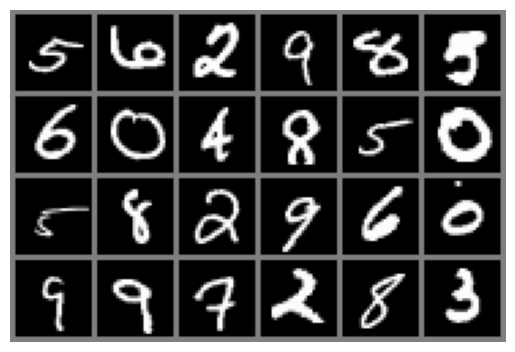

In [24]:
### Optional cell to plot images ###
def imshow(imgs):
    imgs = imgs / 2 + 0.5  # Unnormalize the images: revert the earlier normalization by re-scaling them to [0,1]
    npimgs = imgs.numpy()  # Convert the tensor to a NumPy array for plotting
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))  # Transpose the dimensions from [C, H, W] to [H, W, C] and display image
    plt.axis('off')  # Hide the axes on the plot
    plt.show()  # Display the imageW

dataiter = iter(train_loader) # Create an iterator from the training DataLoader
images, labels = next(dataiter) # Fetch the next batch of images and labels

img_grid = utils.make_grid(images[0:24], nrow=6)  # Create a grid of images using the first 24 images from the batch
imshow(img_grid) # Display the image grid

In [15]:
# Define and initialise the model
# Every model in PyTorch is implemented using a class that inherits from nn.Module
class Net(nn.Module):
    def __init__(self):  # Constructor function to initialize the neural network
        super(Net, self).__init__()  # Call to the parent class (nn.Module) constructor to handle the underlying initialization
        self.fc1 = nn.Linear(784, 128)  # Define the first fully connected (dense) layer with 784 inputs and 128 outputs
        self.fc2 = nn.Linear(128, 64)   # Define the second fully connected layer with 128 inputs and 64 outputs
        self.fc3 = nn.Linear(64, 10)    # Define the third fully connected layer with 64 inputs and 10 outputs, for 10 class outputs

    def forward(self, x):  # Define the forward pass of the network, which outlines how the input 'x' flows through the network
        x = torch.relu(self.fc1(x))  # Apply the ReLU activation function to the output of the first layer
        x = torch.relu(self.fc2(x))  # Apply the ReLU activation function to the output of the second layer
        x = torch.softmax(self.fc3(x), dim=1)  # Apply the softmax activation function to the output of the third layer to normalize the output to a probability distribution over predicted output classes
        return x  # Return the final output of the network
    
model = Net() # add '.to(device)' for hardware targeting (e.g., model.to('cuda') to run the model on a GPU)


In [16]:
# Initialise the optimiser, and loss function
optimizer = optim.Adam(model.parameters(), lr=0.001) # have to use an object from the API class for the optimiser
criterion = nn.CrossEntropyLoss()

In [25]:
# Training loop
model.train()  # Ensure the model is in training mode

# Lists to store training and validation metrics after each epoch
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Iterate over the number of epochs
for epoch in range(10):
    # Initialize metrics for each epoch
    train_loss = 0.0
    train_correct = 0
    train_total = 0

    # Ensure the model is in training mode
    model.train()

    # Iterate over each batch of data
    for data, target in train_loader:
        # Reshape or flatten the data as required by the model
        data = data.view(data.shape[0], -1)  # Flatten the images

        # Zero the gradients from previous iterations (pytorch accumlates gradients on tensoirs from the backpass by default)
        optimizer.zero_grad() # (stops the last gradient(s) calculated in backprop being added, stoping multiple gradients accumulating)

        # Forward pass: 
        output = model(data) # Compute predicted outputs by passing inputs to the model
        loss = criterion(output, target) # Calculate the batch loss using the loss criterion

        # Perform backpropagation
        loss.backward() # Compute gradient of the loss with respect to model parameters
        optimizer.step() # Perform a single optimization step (parameter update)

        # Update training loss and accuracy calculations
        train_loss += loss.item() * data.size(0)
        _, predicted = torch.max(output, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    # Record the average training loss and accuracy for the current epoch
    train_losses.append(train_loss / train_total)
    train_accuracies.append(100 * train_correct / train_total)

    # Validation phase
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    # Set the model to evaluation mode
    model.eval()

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        for data, target in val_loader:
            # Reshape or flatten data
            data = data.view(data.shape[0], -1)

            # Forward pass 
            output = model(data) # Compute predicted outputs by passing inputs to the model
            loss = criterion(output, target)# Calculate the batch loss

            # Update validation loss and accuracy calculations
            val_loss += loss.item() * data.size(0)
            _, predicted = torch.max(output, 1)
            val_total += target.size(0)
            val_correct += (predicted == target).sum().item()

    # Record the average validation loss and accuracy for the current epoch
    val_losses.append(val_loss / val_total)
    val_accuracies.append(100 * val_correct / val_total)

    # Print training/validation statistics
    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

# Indicate that training is finished
print('Finished Training.')

Epoch 1: Train Loss: 1.5037, Train Accuracy: 95.75%, Validation Loss: 1.5050, Validation Accuracy: 95.62%
Epoch 2: Train Loss: 1.5033, Train Accuracy: 95.79%, Validation Loss: 1.5061, Validation Accuracy: 95.51%
Epoch 3: Train Loss: 1.5014, Train Accuracy: 95.99%, Validation Loss: 1.5002, Validation Accuracy: 96.13%
Epoch 4: Train Loss: 1.5014, Train Accuracy: 95.98%, Validation Loss: 1.5047, Validation Accuracy: 95.62%
Epoch 5: Train Loss: 1.4993, Train Accuracy: 96.18%, Validation Loss: 1.4963, Validation Accuracy: 96.51%
Epoch 6: Train Loss: 1.4973, Train Accuracy: 96.39%, Validation Loss: 1.5029, Validation Accuracy: 95.83%
Epoch 7: Train Loss: 1.4974, Train Accuracy: 96.36%, Validation Loss: 1.4985, Validation Accuracy: 96.28%
Epoch 8: Train Loss: 1.4966, Train Accuracy: 96.43%, Validation Loss: 1.4968, Validation Accuracy: 96.42%
Epoch 9: Train Loss: 1.4965, Train Accuracy: 96.44%, Validation Loss: 1.5015, Validation Accuracy: 95.95%
Epoch 10: Train Loss: 1.4943, Train Accuracy: 

In [26]:
# # Alternative Training Loop - if no validation is implemented and no metrics require storing
# model.train()

# for epoch in range(10):
#     for data, target in train_loader:
#         data = data.view(data.shape[0], -1)     # Flatten the images
#         optimizer.zero_grad()                   # Clear the gradients
#         loss = criterion(model(data), target)   # Forward pass and compute the loss
#         loss.backward()                         # Backpropagation
#         optimizer.step()                        # Update the weights
        
#     print(f'Epoch {epoch + 1}: Loss: {loss.item():.4f}')
    
# print('Finished Training.')

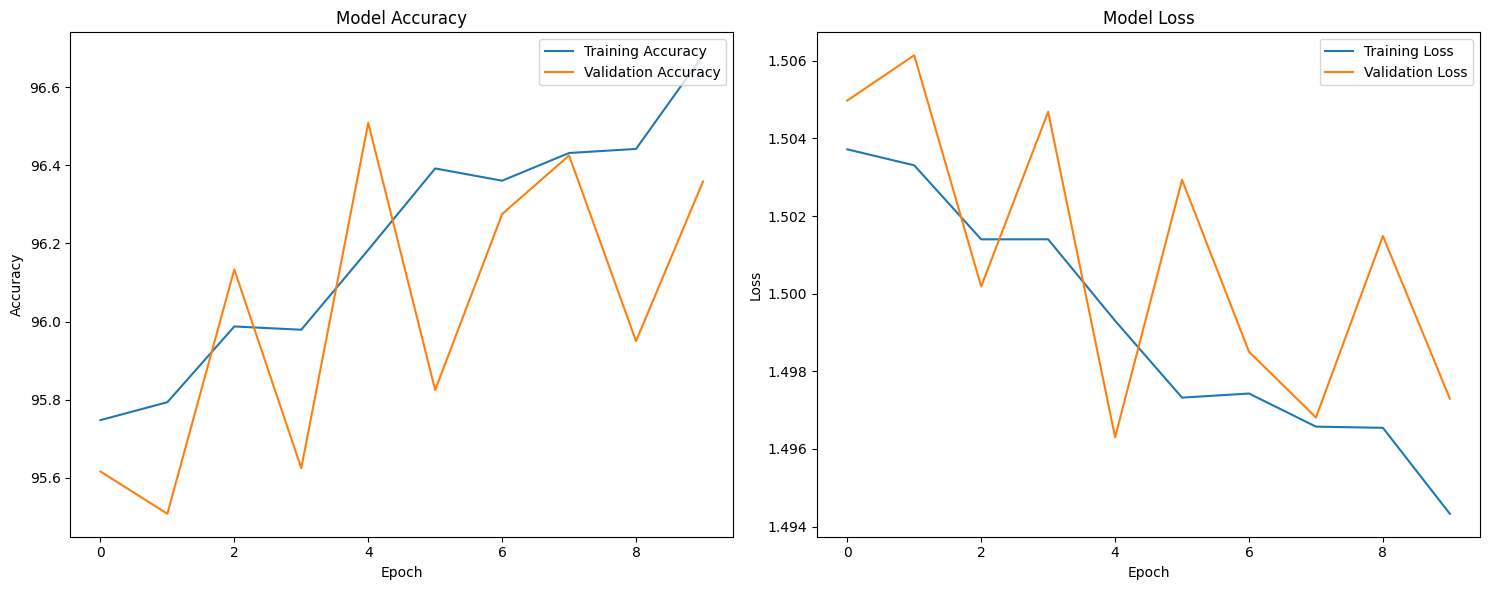

In [27]:
# Plotting the training and validation statistics
plt.figure(figsize=(15, 6))

# Plot training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [28]:
# Evaluation
model.eval() # switch to evaluation mode
correct = 0
total = 0

with torch.no_grad(): # no gradient tracking
    for data, target in test_loader:
        data = data.view(data.shape[0], -1)
        
        outputs = model(data)
        
        # Take class labels with highest probability prediction
        _, predicted = torch.max(outputs.data, 1)
        
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
print(f'Accuracy: {100 * correct / total}%')

Accuracy: 96.21%
